## Detectron2 Training

**Set the following variables, and run all.**

The notebook reports COCO eval metrics and visualizations at the end.

`img_dir`: location of all images (both training and test)

`train_json`: COCO annotation file consisting of training set annotations 

`test_json`: COCO annotation file consisting of test / validation set annotations

`dataset_name`: a name for the dataset, for detectron2 bookkeeping

In [1]:
img_dir = '/checkpoint/dhirajgandhi/active_vision/habitat_data_with_seg/rgb'
# json file where label proogation is performed to nearby 5 images for which have gt acess & neglected floor,ceiling & wall from classes
train_json = '/scratch/dhirajgandhi/droidlet/locobot/label_propogation/json/train_p_5_s_1_e_floor,ceiling,wall.json'
# json file where all the exploration - gt acess & neglected floor,ceiling & wall from classes
test_json = '/scratch/dhirajgandhi/droidlet/locobot/label_propogation/json/test_gt_e_floor,ceiling,wall.json'
dataset_name = 'train'

In [2]:
import torchvision

# import some common libraries
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import random
import os
import numpy as np
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.data import DatasetCatalog, MetadataCatalog

import random
import torch 
import base64
import io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
from PIL import Image

pd.set_option('max_colwidth', 300)

import glob
from IPython.core.display import display, HTML

pd.set_option('max_colwidth', 300)
matplotlib.rcParams['figure.figsize'] = (20, 7.0)

display(HTML(
    """
    <style>
    .container { width:100% !important; }
    #notebook { letter-spacing: normal !important;; }
    .CodeMirror { font-family: monospace !important; }
    .cm-keyword { font-weight: bold !important; color: #008000 !important; }
    .cm-comment { font-style: italic !important; color: #408080 !important; }
    .cm-operator { font-weight: bold !important; color: #AA22FF !important; }
    .cm-number { color: #080 !important; }
    .cm-builtin { color: #008000 !important; }
    .cm-string { color: #BA2121 !important; }
    </style>
    """
))

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



## Detectron2 Setup

In [3]:
DatasetCatalog.clear()

train_data = dataset_name +  "_train"
val_data = dataset_name + "_val"
from detectron2.data.datasets import register_coco_instances
register_coco_instances(train_data, {}, train_json, img_dir)
register_coco_instances(val_data, {}, test_json, img_dir)

In [4]:
from detectron2.data import DatasetMapper, build_detection_train_loader

MetadataCatalog.get(train_data)

namespace(name='train_train',
          json_file='/scratch/dhirajgandhi/droidlet/locobot/label_propogation/json/train_p_5_s_1_e_floor,ceiling,wall.json',
          image_root='/checkpoint/dhirajgandhi/active_vision/habitat_data_with_seg/rgb',
          evaluator_type='coco')

## Visualizing the dataset

WARNING [03/12 14:45:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/12 14:45:23 d2.data.datasets.coco]: Loaded 1304 images in COCO format from /scratch/dhirajgandhi/droidlet/locobot/label_propogation/json/train_p_5_s_1_e_floor,ceiling,wall.json


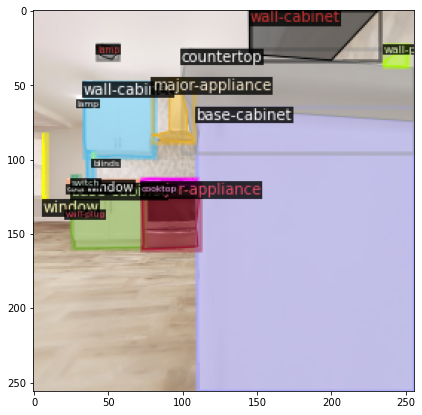

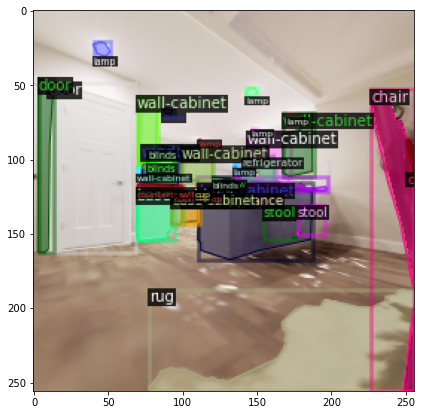

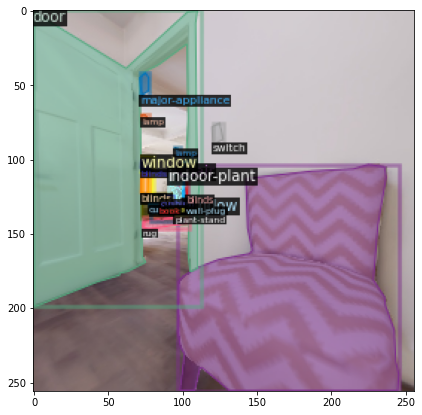

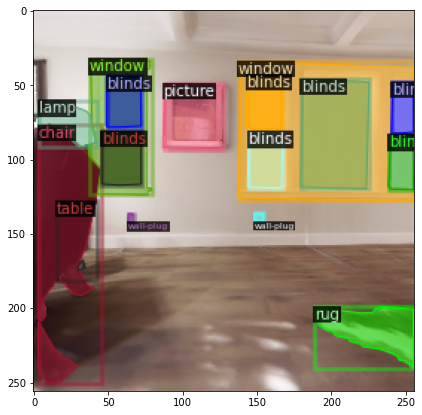

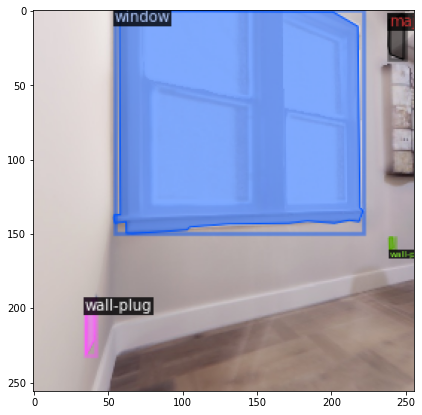

In [5]:
import random

dataset_dicts = DatasetCatalog.get(train_data)

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(train_data), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    img = vis.get_image()
    plt.imshow(img)
    plt.show()

In [6]:
coco_yaml = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
lvis_yaml = "LVIS-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
lvis_yaml2 = "LVIS-InstanceSegmentation/mask_rcnn_R_101_FPN_1x.yaml"
pano_yaml = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"

In [10]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(coco_yaml))
cfg.DATASETS.TRAIN = (train_data,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(coco_yaml)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.005  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(train_data).get("thing_classes"))  # only has one class (ballon)

## Training

In [11]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

[03/12 15:17:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [03/12 15:17:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/12 15:17:57 d2.data.datasets.coco]: Loaded 1304 images in COCO format from /scratch/dhirajgandhi/droidlet/locobot/label_propogation/json/train_p_5_s_1_e_floor,ceiling,wall.json
[03/12 15:17:57 d2.data.build]: Removed 0 images with no usable annotations. 1304 images left.
[03/12 15:17:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/12 15:17:57 d2.data.build]: Using training sampler TrainingSampler
[03/12 15:17:57 d2.data.common]: Serializing 1304 elements to byte tensors and concatenating them all ...
[03/12 15:17:57 d2.data.common]: Serialized dataset takes 8.35 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (99, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (99,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (392, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (392,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (98, 256, 1

[03/12 15:17:57 d2.engine.train_loop]: Starting training from iteration 0
[03/12 15:18:02 d2.utils.events]:  eta: 0:03:53  iter: 19  total_loss: 7.84  loss_cls: 4.284  loss_box_reg: 0.7919  loss_mask: 0.692  loss_rpn_cls: 1.537  loss_rpn_loc: 0.4426  time: 0.2393  data_time: 0.0176  lr: 9.9905e-05  max_mem: 1866M
[03/12 15:18:07 d2.utils.events]:  eta: 0:03:44  iter: 39  total_loss: 3.898  loss_cls: 1.778  loss_box_reg: 0.735  loss_mask: 0.6828  loss_rpn_cls: 0.2101  loss_rpn_loc: 0.3728  time: 0.2348  data_time: 0.0043  lr: 0.0001998  max_mem: 1866M
[03/12 15:18:11 d2.utils.events]:  eta: 0:03:39  iter: 59  total_loss: 3.602  loss_cls: 1.525  loss_box_reg: 0.8235  loss_mask: 0.6626  loss_rpn_cls: 0.1552  loss_rpn_loc: 0.4269  time: 0.2332  data_time: 0.0042  lr: 0.0002997  max_mem: 1866M
[03/12 15:18:16 d2.utils.events]:  eta: 0:03:34  iter: 79  total_loss: 3.326  loss_cls: 1.397  loss_box_reg: 0.7811  loss_mask: 0.6356  loss_rpn_cls: 0.1283  loss_rpn_loc: 0.3839  time: 0.2327  data_t

[03/12 15:20:33 d2.utils.events]:  eta: 0:01:20  iter: 659  total_loss: 1.587  loss_cls: 0.2689  loss_box_reg: 0.4726  loss_mask: 0.253  loss_rpn_cls: 0.04879  loss_rpn_loc: 0.4952  time: 0.2351  data_time: 0.0048  lr: 0.0032967  max_mem: 1866M
[03/12 15:20:38 d2.utils.events]:  eta: 0:01:15  iter: 679  total_loss: 1.363  loss_cls: 0.2239  loss_box_reg: 0.4308  loss_mask: 0.241  loss_rpn_cls: 0.04245  loss_rpn_loc: 0.3978  time: 0.2349  data_time: 0.0043  lr: 0.0033966  max_mem: 1866M
[03/12 15:20:42 d2.utils.events]:  eta: 0:01:10  iter: 699  total_loss: 1.438  loss_cls: 0.2508  loss_box_reg: 0.4686  loss_mask: 0.2493  loss_rpn_cls: 0.06353  loss_rpn_loc: 0.4165  time: 0.2348  data_time: 0.0042  lr: 0.0034965  max_mem: 1866M
[03/12 15:20:47 d2.utils.events]:  eta: 0:01:05  iter: 719  total_loss: 1.508  loss_cls: 0.2804  loss_box_reg: 0.5009  loss_mask: 0.2711  loss_rpn_cls: 0.04805  loss_rpn_loc: 0.4297  time: 0.2348  data_time: 0.0041  lr: 0.0035964  max_mem: 1866M
[03/12 15:20:52 d2

Reusing TensorBoard on port 6007 (pid 1819821), started 3 days, 2:00:55 ago. (Use '!kill 1819821' to kill it.)

## Evaluation

In [12]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(val_data, ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, val_data)
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/12 15:51:51 d2.data.datasets.coco]: Loading /scratch/dhirajgandhi/droidlet/locobot/label_propogation/json/test_gt_e_floor,ceiling,wall.json takes 2.43 seconds.
WARNING [03/12 15:51:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/12 15:51:51 d2.data.datasets.coco]: Loaded 8791 images in COCO format from /scratch/dhirajgandhi/droidlet/locobot/label_propogation/json/test_gt_e_floor,ceiling,wall.json
[03/12 15:51:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/12 15:51:52 d2.data.common]: Serializing 8791 elements to byte tensors and concatenating them all ...
[03/12 15:51:53 d2.data.common]: Serialized dataset takes 54.47 MiB
[03/12 15:51:53 d2.evaluation.evaluator]: Start inference on 8791 images
[03/12 15:51:55 d2.evaluation.evaluator]: Inference done 11/8791. 0.0696 s / img. ETA=0:20:20
[03

[03/12 15:57:44 d2.evaluation.evaluator]: Inference done 3156/8791. 0.0651 s / img. ETA=0:10:25
[03/12 15:57:49 d2.evaluation.evaluator]: Inference done 3211/8791. 0.0652 s / img. ETA=0:10:17
[03/12 15:57:54 d2.evaluation.evaluator]: Inference done 3272/8791. 0.0651 s / img. ETA=0:10:07
[03/12 15:57:59 d2.evaluation.evaluator]: Inference done 3332/8791. 0.0650 s / img. ETA=0:09:58
[03/12 15:58:04 d2.evaluation.evaluator]: Inference done 3384/8791. 0.0650 s / img. ETA=0:09:51
[03/12 15:58:09 d2.evaluation.evaluator]: Inference done 3434/8791. 0.0650 s / img. ETA=0:09:45
[03/12 15:58:14 d2.evaluation.evaluator]: Inference done 3481/8791. 0.0650 s / img. ETA=0:09:40
[03/12 15:58:19 d2.evaluation.evaluator]: Inference done 3529/8791. 0.0650 s / img. ETA=0:09:34
[03/12 15:58:24 d2.evaluation.evaluator]: Inference done 3577/8791. 0.0649 s / img. ETA=0:09:29
[03/12 15:58:29 d2.evaluation.evaluator]: Inference done 3631/8791. 0.0649 s / img. ETA=0:09:22
[03/12 15:58:34 d2.evaluation.evaluator]

[03/12 16:04:22 d2.evaluation.evaluator]: Inference done 7403/8791. 0.0635 s / img. ETA=0:02:20
[03/12 16:04:27 d2.evaluation.evaluator]: Inference done 7468/8791. 0.0635 s / img. ETA=0:02:13
[03/12 16:04:32 d2.evaluation.evaluator]: Inference done 7531/8791. 0.0635 s / img. ETA=0:02:06
[03/12 16:04:37 d2.evaluation.evaluator]: Inference done 7597/8791. 0.0634 s / img. ETA=0:02:00
[03/12 16:04:43 d2.evaluation.evaluator]: Inference done 7663/8791. 0.0634 s / img. ETA=0:01:53
[03/12 16:04:48 d2.evaluation.evaluator]: Inference done 7724/8791. 0.0634 s / img. ETA=0:01:46
[03/12 16:04:53 d2.evaluation.evaluator]: Inference done 7784/8791. 0.0633 s / img. ETA=0:01:40
[03/12 16:04:58 d2.evaluation.evaluator]: Inference done 7845/8791. 0.0633 s / img. ETA=0:01:34
[03/12 16:05:03 d2.evaluation.evaluator]: Inference done 7915/8791. 0.0633 s / img. ETA=0:01:27
[03/12 16:05:08 d2.evaluation.evaluator]: Inference done 7985/8791. 0.0632 s / img. ETA=0:01:20
[03/12 16:05:13 d2.evaluation.evaluator]

[03/12 16:07:53 d2.evaluation.coco_evaluation]: Evaluation results for segm: 
|   AP   |  AP50  |  AP75  |  APs   |  APm   |  APl   |
|:------:|:------:|:------:|:------:|:------:|:------:|
| 28.944 | 56.372 | 26.305 | 17.533 | 39.280 | 49.931 |
[03/12 16:07:53 d2.evaluation.coco_evaluation]: Per-category segm AP: 
| category        | AP     | category         | AP     | category          | AP     |
|:----------------|:-------|:-----------------|:-------|:------------------|:-------|
| backpack        | nan    | base-cabinet     | 56.815 | basket            | 9.577  |
| bathtub         | nan    | beam             | nan    | beanbag           | nan    |
| bed             | nan    | bench            | nan    | bike              | nan    |
| bin             | nan    | blanket          | nan    | blinds            | 51.314 |
| book            | 8.630  | bottle           | 26.447 | box               | nan    |
| bowl            | nan    | camera           | nan    | cabinet           | 53.4

In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (val_data, )
predictor = DefaultPredictor(cfg)


def visualize(filename):
    im = cv2.imread(filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(val_data), 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    plt.show()

for d in DatasetCatalog.get(val_data):
    print(d['file_name'])
    visualize(d['file_name'])
